In [1]:
import numpy as np
import scipy as sp
import scipy.fftpack
from matplotlib import pyplot as plt
import scipy.io
import lib
np.random.seed(666)

In [2]:
rootfolder = '..'

Generating 1-D DCT basis
------------------------


In [3]:
M = 128 # signal dimension
N = M # nr of atoms in the basis (this will be different when using redundant set of generators)

D = np.zeros((M, N)) # matrix containing the DCT basis (a DCT function in each column)
DCT = lib.dct_matrix(M)
DCT.shape

(128, 128)

Display an atom of the dct basis

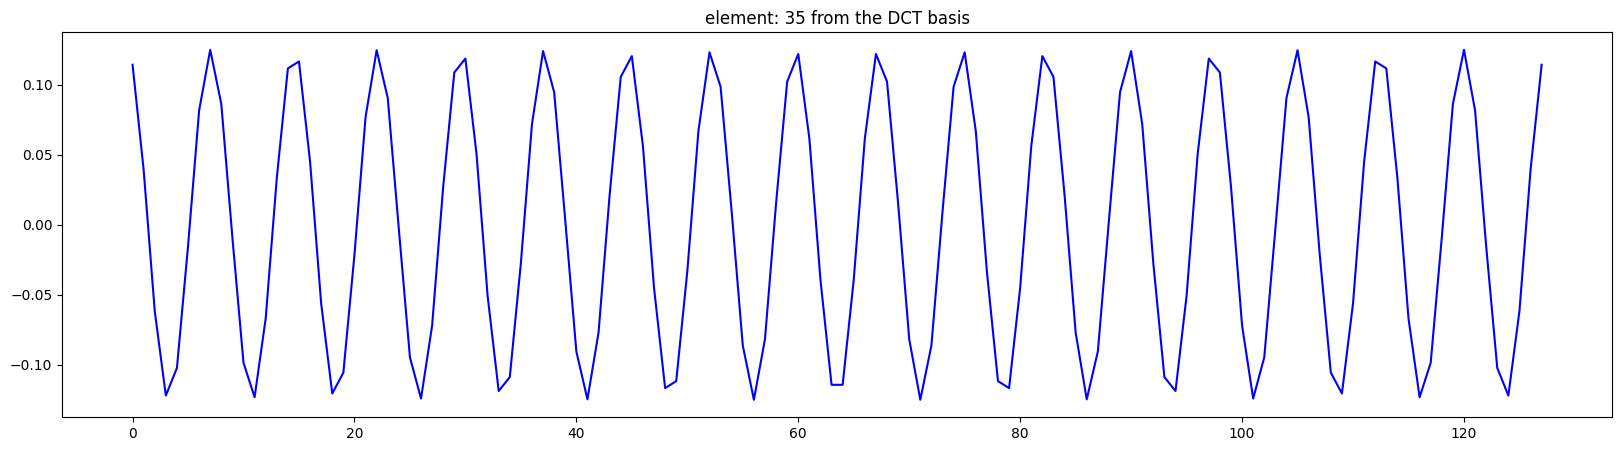

In [4]:
k = 34
plt.figure(figsize=(20, 5))
plt.plot(DCT[:, k], 'b')
plt.title(f'element: {k+1} from the DCT basis');

Check orthogonality

In [5]:
is_DCT_orth = np.allclose(DCT.T @ DCT, np.eye(M))
print(f'DCT dictionary is orthogonal: {is_DCT_orth}')

DCT dictionary is orthogonal: True


Display the basis in the matrix

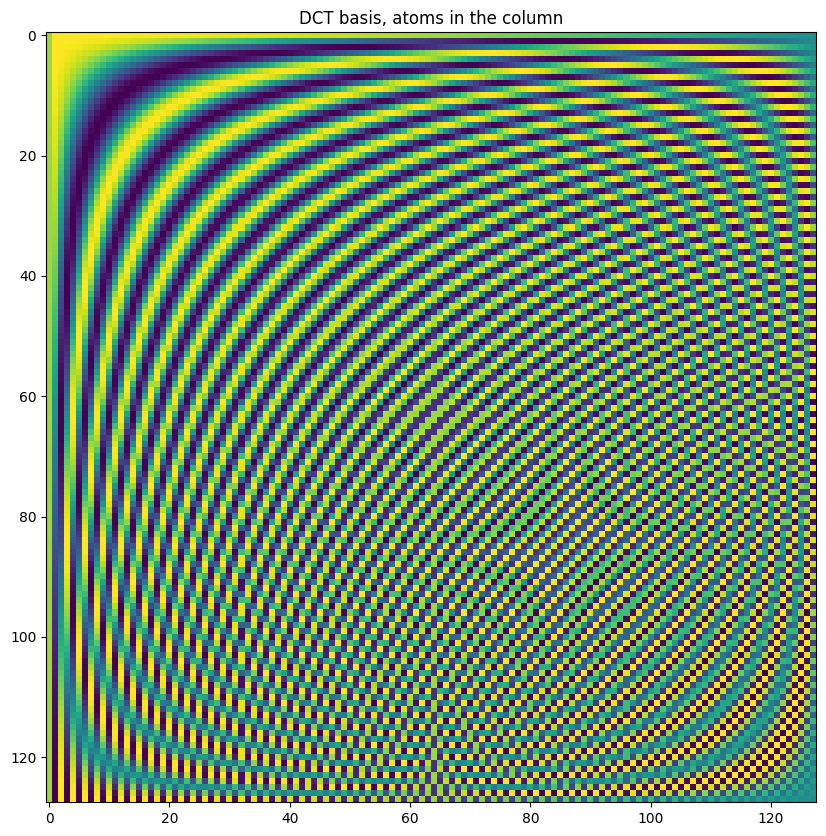

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column');

Generate 1D DCT basis using the function idct
---------------------------------------------
idct is the inverse dct transform stack this in the matrix D

In [7]:
D = sp.fftpack.idct(np.eye(M), norm='ortho', axis=0)
D.shape

(128, 128)

Display the basis in the matrix

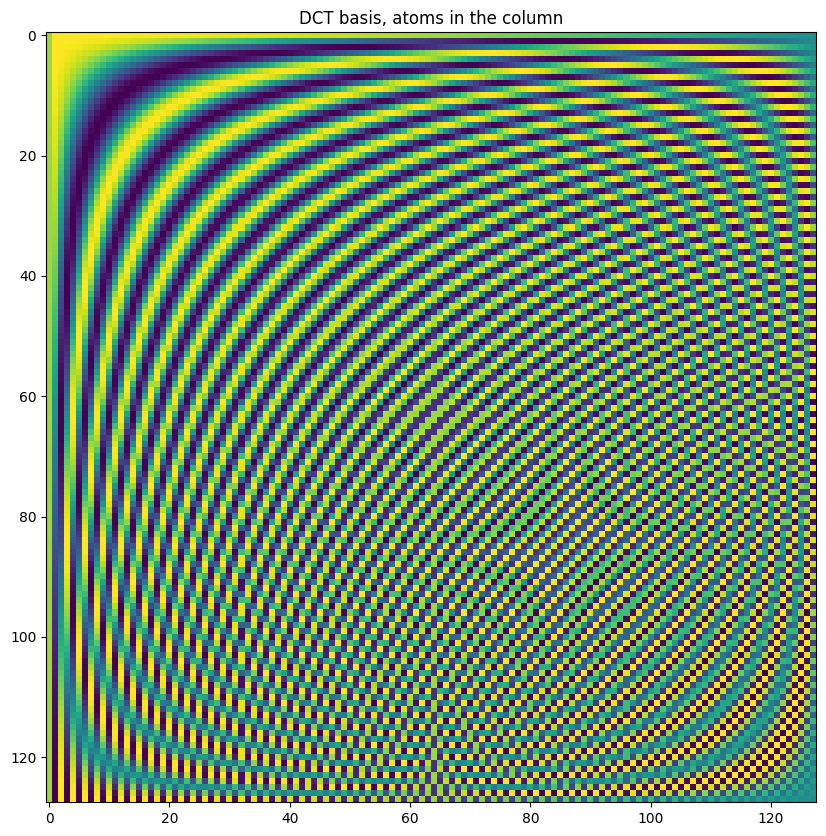

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title('DCT basis, atoms in the column');

Check that D and DCT defined above coincide

In [9]:
is_DCT_equal_D = np.allclose(D, DCT)
print(f'D and DCT are equal: {is_DCT_equal_D}')

D and DCT are equal: True


Analysis: compute the representation of an input ECG signal
-----------------------------------------------------------
Load few ECG signals to be processed

In [10]:
temp = scipy.io.loadmat(f'{rootfolder}/data/croppedECG.mat')
nBeats = 10
S = temp['S'][:, :nBeats]

Compute the representation coefficients

In [11]:
X = D.T @ S
X.shape

(128, 10)

Display a signal and its representation coefficients

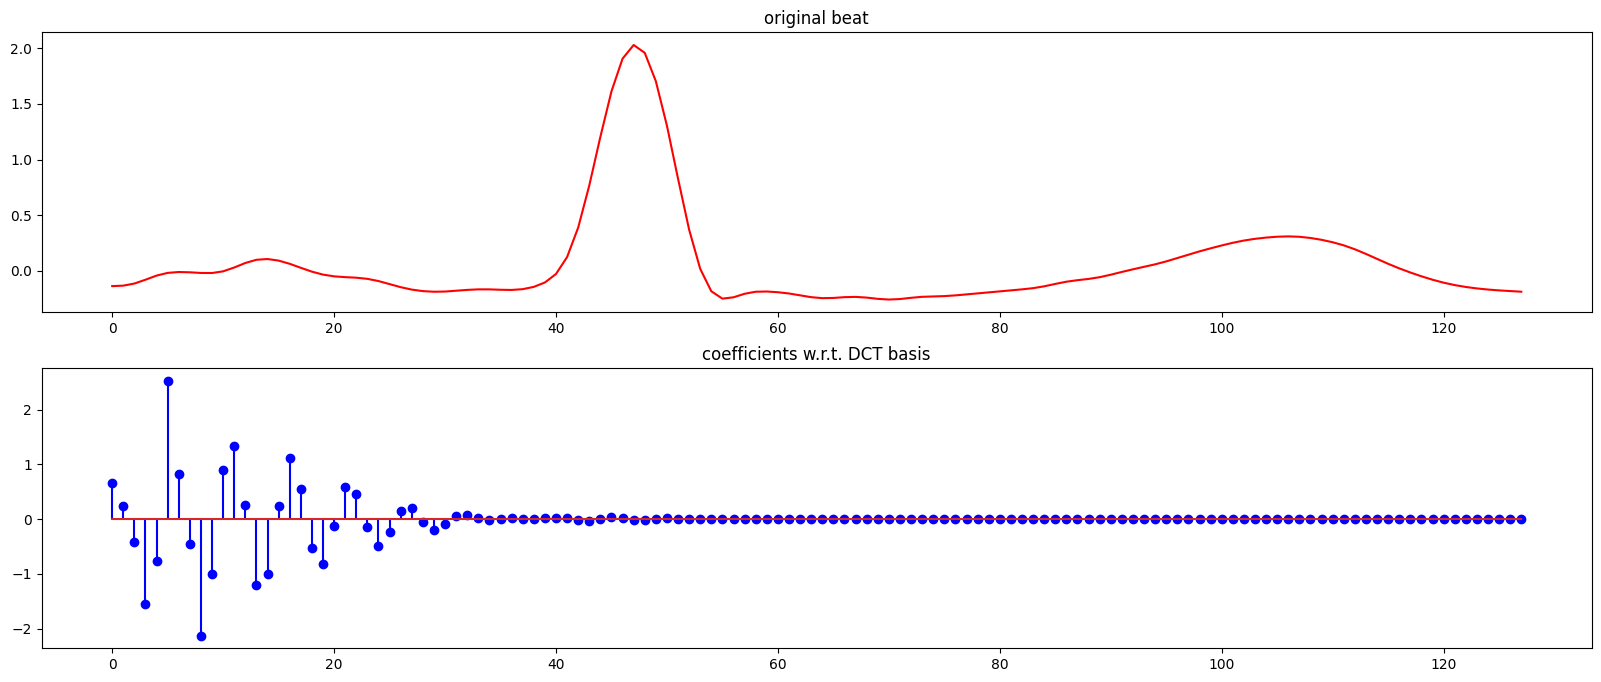

In [12]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.stem(X[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis');

Synthesis: reconstruct all the ECG signals from their representations
---------------------------------------------------------------------
Reconstruct the two signals (express them w.r.t. the standard basis)

In [13]:
S_hat_D = D @ X
S_hat_D.shape

(128, 10)

Check if there is perfect reconstruction.

It is trivial because $\hat S_D = DD^TS$ and $DD^T = I_M$  since $D$ is orthonormal (the same applies to $C$)

In [14]:
is_reconstruction_perfect = np.allclose(S, S_hat_D)
print(f'The reconstruction is perfect: {is_reconstruction_perfect}')

The reconstruction is perfect: True


Add noise to ECG data and inspect the representations
-----------------------------------------------------


In [15]:
sigma_noise = 0.1
S_noisy = S + sigma_noise * np.random.normal(size=S.shape)

Compute the representation coefficients

In [16]:
X = D.T @ S_noisy
X.shape

(128, 10)

Display a signal and its representation coefficients

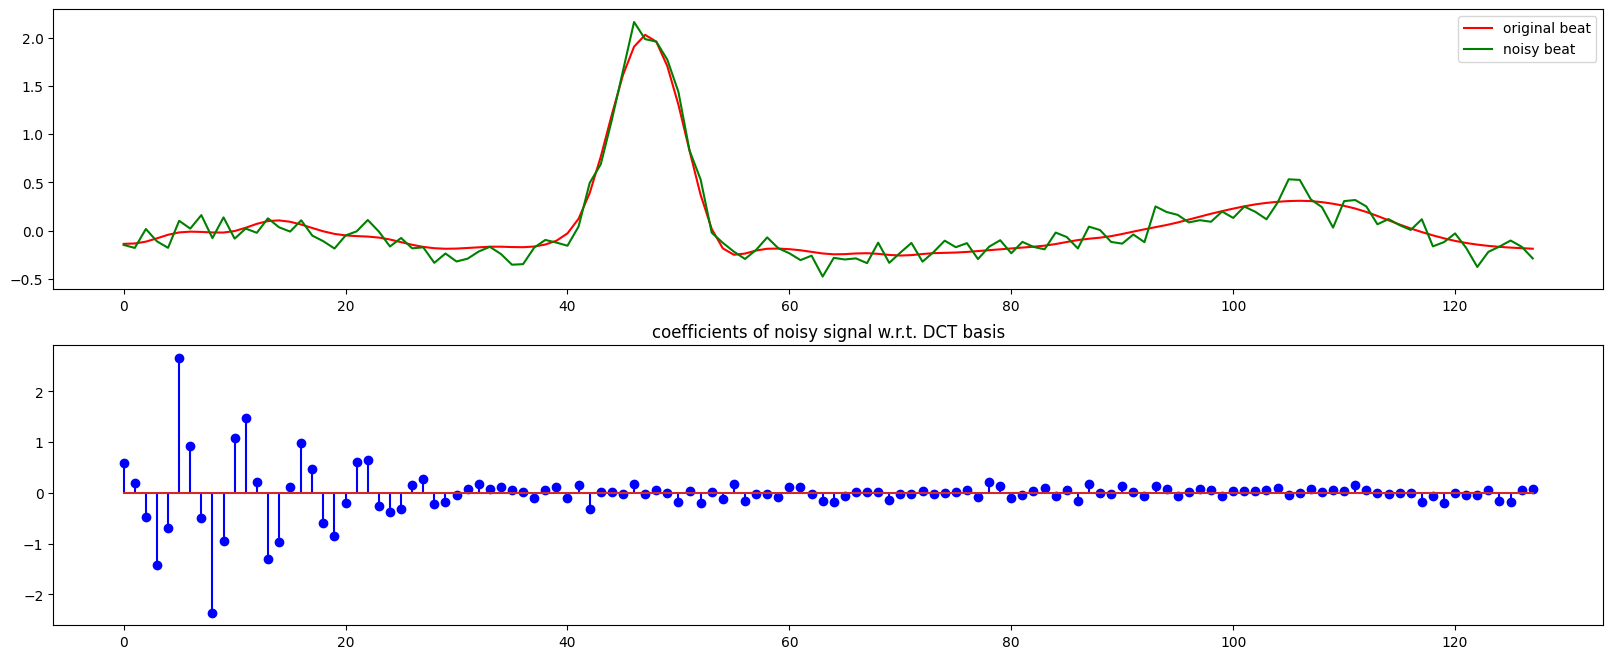

In [17]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))
ax1.plot(S[:, i], 'r', label='original beat')
ax1.plot(S_noisy[:, i], 'g', label='noisy beat')
ax2.stem(X[:, i], 'b')
ax2.set_title('coefficients of noisy signal w.r.t. DCT basis');
ax1.legend()
plt.show()

Hard Thresholding
-----------------
Noise affects all the coefficients of our transformation

Keep only $L$ coefficients having largest magnitude

In [18]:
def denoise(X, L):
    to_cut = np.argsort(np.abs(X), axis=0)[:-L, :]
    X_HT = X.copy()
    X_HT[to_cut] = 0
    return D @ X_HT, X_HT

In [19]:
L = 21
S_hat, X_HT = denoise(X, L)
X_HT.shape, S_hat.shape 

((128, 10), (128, 10))

Display a signal

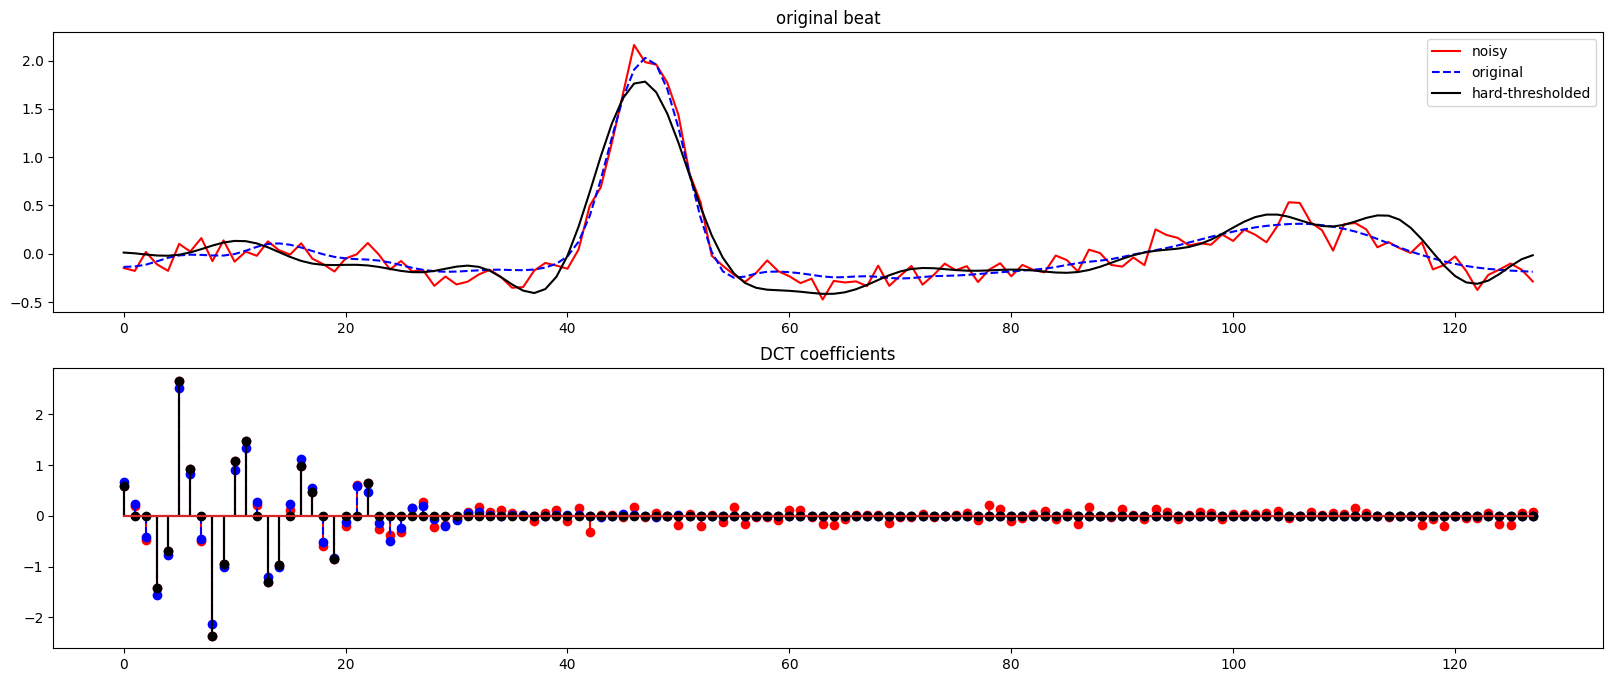

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))
ax1.plot(S_noisy[:, i], 'r')
ax1.plot(S[:, i], 'b--')
ax1.plot(S_hat[:, i], 'k')
ax1.legend(['noisy', 'original', 'hard-thresholded'])
ax1.set_title('original beat')

# coefficients of the noisy signal
ax2.stem(D.T @ S_noisy[:, i], 'r.')
# coefficients of the noise free signal
ax2.stem(D.T @ S[:, i], 'b--')
ax2.stem(np.arange(M), X_HT[:, i], 'k')
ax2.set_title('DCT coefficients');

Compression
-----------
Try to compress a heartbeat using different value of $L$ and plot the mean squared error corresponding to each $L$

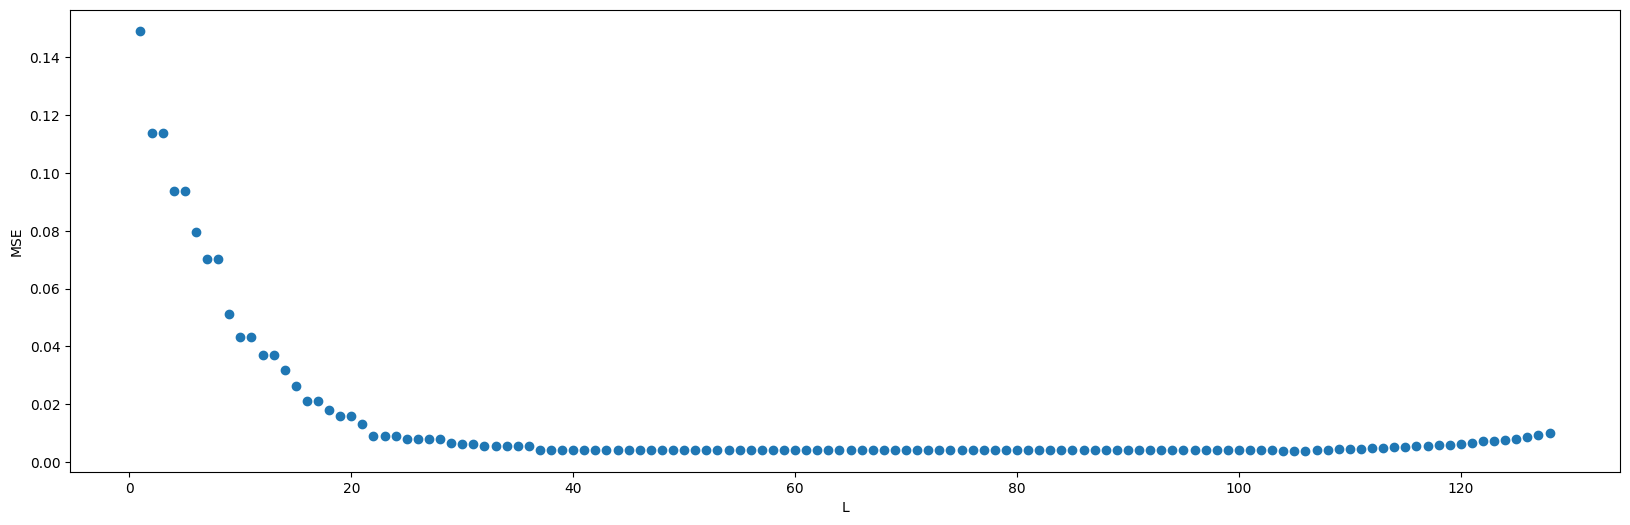

In [21]:
# x_HT = np.zeros((M)) # initialize the matrix of representations of S w.r.t. D
# s_hat = np.zeros((M))

L_values = np.arange(1, M+1)
MSE_values = np.zeros(M)

origSignal = S[:, 0]

for L in L_values:
    S_hat, _ = denoise(X, L)
    MSE_values[L-1] = np.mean(np.square(S_hat - S))

plt.figure(figsize=(20,6))
plt.scatter(L_values, MSE_values);
plt.ylabel('MSE')
plt.xlabel('L')
plt.show()